# Assembly of the Biot equations

In this tutorial we demonstrate how to assemble and solve the multi-physics Biot problem in PorePy. This tutorial will focus on a 2d domain. However, most of the code works for 1d, 2d, and 3d domains.<br>

Let $\Omega$ be a regular domain with boundary $\partial \Omega$. We indicate the outward unit normal vector of $\partial \Omega$ by $\mathbf{n}$.<br>
The Biot equations formulation read:
$$ \nabla \cdot \frac{1}{2}D(\nabla \mathbf{u} + \nabla \mathbf{u}^T) - \alpha \nabla p = F \\
\frac{\partial}{\partial t}(\beta p + \alpha \nabla \cdot \mathbf{u}) - \nabla \cdot K \nabla p = f$$
with boundary conditions on $\partial \Omega_d$ and $\partial \Omega_n$:
$$ p = p_b \qquad \quad \qquad - K \nabla p \cdot \mathbf{n} = v_b$$
$$ \mathbf{u} = \mathbf{u}_b \qquad \frac{1}{2}D(\nabla \mathbf{u} + \nabla \mathbf{u}^T) \cdot \mathbf{n} = t_b$$

In the above, the unknowns are the displacements $\mathbf{u}$ and the pressure $p$. The parameters are the scalar and vector source/sink terms $F$ and $f$, the permeability matrix $K$, the stiffness matrix $D$, the Biot coefficient $\alpha$, the fluid compressibility and density $\beta$ and $\rho$ and the gravity vector $\mathbf{g}$. $p_b$ is the pressure at the boundary (Dirichlet condition), $v_p$ is the flux at the boundary (Neumann condition), $\mathbf{u}_b$ is the displacement at the boundary (Dirichlet condition) and $t_b$ is the traction at the boundary (Neumann condition).<br>

We present step-by-step how to create the grid, declare the problem data, assemble the system of equations and finally solve the problem.
We start by importing some modules.

In [1]:
import numpy as np
import scipy.sparse as sps
import matplotlib.pyplot as plt

import porepy as pp

In [2]:
def make_grid(nx=[4, 4]):
    # Define a grid for a toy problem
    gb = pp.meshing.cart_grid([], nx)
    gb.compute_geometry()
    gb.assign_node_ordering()
    return gb


Methods to assign data and initial conditions. We will mainly use default values for parameters, while overriding some of the values. 

In [3]:
def assign_data(g, d, parameter_keyword_flow, parameter_keyword_mechanics):
    
    # Assign a non-default permeability and compressibility, for illustrative purposes
    k = 2 * np.ones(g.num_cells)
    perm = pp.SecondOrderTensor(gb.dim_max(), k)
    fluid_compressibility = 0.1 * np.ones(g.num_cells)
    
    bound_faces = g.get_all_boundary_faces()
    bound_flow = pp.BoundaryCondition(
        g, bound_faces.ravel("F"), ["dir"] * bound_faces.size
    )
    bound_mech = pp.BoundaryConditionVectorial(
        g, bound_faces.ravel("F"), ["dir"] * bound_faces.size
    )
    boundary_values_flow = np.zeros(g.num_faces)
    boundary_values_flow[0] = 1
    
    
    # Create a dictionary to override the default parameters
    specified_parameters_flow = {"second_order_tensor": perm, "biot_alpha": 1,
                                 "bc": bound_flow, "bc_values": boundary_values_flow,
                                "time_step": 0.3, "mass_weight": fluid_compressibility}
    specified_parameters_mechanics = {"biot_alpha": 1, "bc": bound_mech}

    # Initialize the parameters for flow and transport.
    # The following keywords are used to define which set of default parameters to pick, i.e. the
    # type of parameters. For example, initialize_default_data initializes a second order permeability
    # tensor in the flow data, and a fourth order stiffness tensor in the mechanics data.
    parameter_type_flow = "flow"
    parameter_type_mechanics = "mechanics"
    pp.initialize_default_data(g, d, parameter_type_flow, specified_parameters_flow,
                               parameter_keyword_flow)
    pp.initialize_default_data(g, d, parameter_type_mechanics, specified_parameters_mechanics,
                               parameter_keyword_mechanics)


In [4]:
def initial_condition(g, d, kw_f, kw_m):
    d_0 = np.zeros((g.dim, g.num_cells))
    d_0[0,:] = 1
    d_0 = d_0.ravel('F')
    p_0 = np.ones(g.num_cells)
    p_0[-1] = 2
    x_0 = np.concatenate((d_0, p_0))
    d["state"] = x_0
    d[pp.PARAMETERS][kw_f]["state"] = p_0
    d[pp.PARAMETERS][kw_m]["state"] = {"displacement": d_0, "bc_values": np.zeros(g.dim * g.num_faces)}
    return d_0, p_0

## Problem setup
The practical way of setting up a problem on a single grid with two variables and multiple terms is described here. First, we define a grid and assign data, which we tag with a keyword. The purpose of this keyword is for the discretization operators (such as `pp.Mpsa()` below) to identify which parameters to use. For more details and explanations, see the tutorial on parameter assignment.

In [5]:
# Define a grid
gb = make_grid()
g = gb.grids_of_dimension(2)[0]
d = gb.node_props(g)
# Assign data, tagging them with the following keywords
kw_f = "flow"
kw_m = "mechanics"
assign_data(g, d, kw_f, kw_m)
d_0, p_0 = initial_condition(g, d, kw_f, kw_m)

Now, discretize the mechanics related terms using the Biot class. This is a dirty trick to ensure efficient discretization where we re-use the local gradient systems of MPSA (see pp/numerics/fv/mpsa.py) for all the mechanical terms involved.

In [6]:
biot_discretizer = pp.Biot()
biot_discretizer._discretize_mech(g, d)

number of ncasym eliminated:  0
max igrad:  2.0


## Assembly
The equations we assemble are a *discretized* version of the Biot equations. This requires a spatial discretization of the individual terms, taken care of by objects such as e.g. `pp.Mpsa` for the $\nabla \cdot \frac{1}{2}D(\nabla \mathbf{u} + \nabla \mathbf{u}^T)$ term, see below. However, a *temporal* discretization must also be chosen, with some implications on the assembly. In this case, we use the Implicit Euler. This means we have to change the standard PorePy discretization objects for the mass term $\frac{\partial}{\partial t}\beta p$ and the flow term $\nabla \cdot K \nabla p$. The former has to return a term to the right hand side, whereas the latter must be multiplied by the time step. To this end, we design two modified discretization objects:

In [7]:
class ImplicitMassMatrix(pp.MassMatrix):
    def assemble_rhs(self, g, data):
        """ Overwrite MassMatrix method to
        Return the correct rhs for an IE time discretization of the Biot problem.

        """
        parameter_dictionary = data[pp.PARAMETERS][self.keyword]
        matrix_dictionary = data[pp.DISCRETIZATION_MATRICES][self.keyword]
        previous_pressure = parameter_dictionary["state"]

        return matrix_dictionary["mass"] * previous_pressure


class ImplicitMpfa(pp.Mpfa):
    def assemble_matrix_rhs(self, g, data):
        """ Overwrite MPSA method to
        Be consistent with the Biot dt convention.
        """
        a, b = super().assemble_matrix_rhs(g, data)
        dt = data[pp.PARAMETERS][self.keyword]["time_step"]
        return a * dt, b * dt

The assembly requires some information about the relationship between variables, terms (of the equation) and discretization objects to be stored in the data dictionary `d`. The information includes the names of the primary variables and identification of the terms of the equations and which objects to discretize them with. Note that the numbering of the terms (i and j in "term_ij") corresponds to the Biot equation as defined above, since stress equals stiffness tensor times the symmetric gradient of displacement.

In [8]:
# Variable names
v_0 = "displacement"
v_1 = "pressure"
# Names of the five terms of the equation + additional stabilization term.
#                                        Term in the Biot equation:
term_00 = "stress_divergence"          # div symmetric grad u
term_01 = "pressure_gradient"          # alpha grad p
term_10 = "displacement_divergence"    # d/dt alpha div u
term_11_0 = "fluid_mass"               # d/dt beta p
term_11_1 = "fluid_flux"               # div (rho g - K grad p)
term_11_2 = "stabilization"            #

# Store in the data dictionary d and specify discretization objects.
d[pp.PRIMARY_VARIABLES] = {v_0: {"cells": g.dim}, v_1: {"cells": 1}}
d[pp.DISCRETIZATION] = {
    v_0: {term_00: pp.Mpsa(kw_m)},
    v_1: {
        term_11_0: ImplicitMassMatrix(kw_f),
        term_11_1: ImplicitMpfa(kw_f),
        term_11_2: pp.BiotStabilization(kw_f),
    },
    v_0 + "_" + v_1: {term_01: pp.GradP(kw_m)},
    v_1 + "_" + v_0: {term_10: pp.DivD(kw_m)},
}

The ordering of the unknowns in the global linear system will vary depending on how the components in the GridBucket (in the case of multi-dimensional problems) and the unknowns are traversed. Untangling the ordering is a two-stage process:
1. The system is ordered as a block system, with one block per combination of primary variable and grid or edge (between grids). This information is storedin the field `block_dof`.
2. For each block, the local degrees of freedom can be obtained from the field `full_dof`.

To get the block number of a specific primary variable, we need the identifier of the relevant component in the GridBucket (either the grid, or the edge between grids), and the variable name. Getting the grids is easy, there is only one, namely g. Now, the block ordering is obtained for the two variables, before we translate into global degrees of freedom. We write a utility function for extracting the displacement and pressure part of the solution vector.

In [9]:
def extract_pressure_and_displacement(x, block_dof, full_dof, g, v_0, v_1):
    block_v0 = block_dof[(g, v_0)]
    block_v1 = block_dof[(g, v_1)]

    # full_dof contains the number of dofs per block. To get a global ordering, use
    global_dof = np.r_[0, np.cumsum(full_dof)]

    # Get the global displacement and pressure dofs
    global_displacement_dof = np.arange(global_dof[block_v0], global_dof[block_v0+1])
    global_pressure_dof = np.arange(global_dof[block_v1], global_dof[block_v1+1])
    return x[global_pressure_dof], x[global_displacement_dof]

Assembly of the global linear system can in many cases be carried out by a single function call of the assembler. Note that for the current problem, this is not possible. Rather, we had to discretize first by calling `biot_discretizer._discretize_mech(g, d)`.
Below, A is the global linear system and b is the corresponding right hand side. We obtain the displacement and pressure solution by solving the linear system. We solve the transient system for three time steps, updating the solution vectors in the data dictionary for each step, and also storing all solutions for examination.

In [10]:
assembler = pp.Assembler(gb)
time_steps = np.arange(3)
stored_pressures = []
stored_displacements = []
for _ in time_steps:
    A, b = assembler.assemble_matrix_rhs()
    x = sps.linalg.spsolve(A, b)
    d["state"] = x
    pressure, displacement = extract_pressure_and_displacement(x, assembler.block_dof, assembler.full_dof, g, v_0, v_1)
    d[pp.PARAMETERS][kw_f]["state"] = pressure
    d[pp.PARAMETERS][kw_m]["state"]["displacement"] = displacement
    stored_pressures.append(pressure)
    stored_displacements.append(displacement)

## Visualization
We visualize the initial condition and the final solution cell-wise using PorePy's plotting functionality, representing the pressure by colors and displacement by arrows. To plot the displacement vectors, we first need to reshape them and add a zero value for the z direction. We also scale the values using the `vector_scale` argument for visualization purposes.

/home/rbe051/anaconda3/envs/porepy/lib/python3.6/site-packages/mpl_toolkits/mplot3d/axes3d.py:738: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  'bottom=%s, top=%s') % (bottom, top))


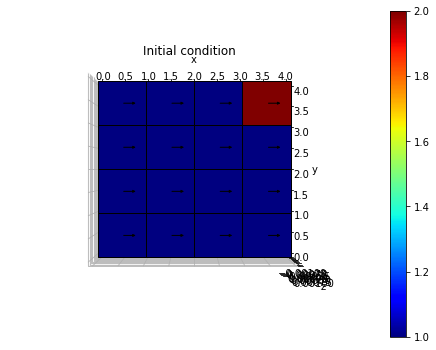

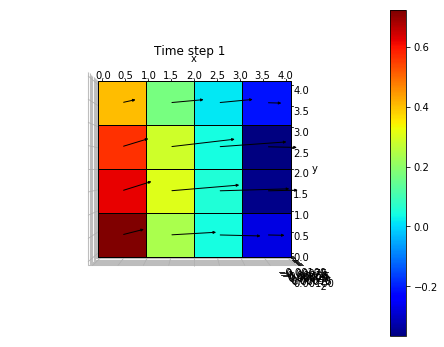

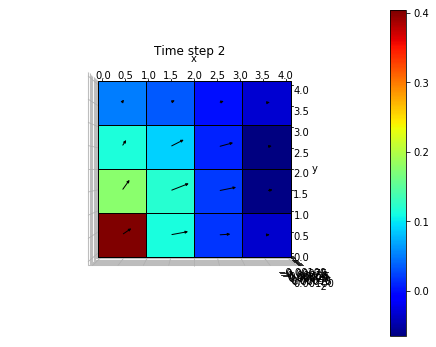

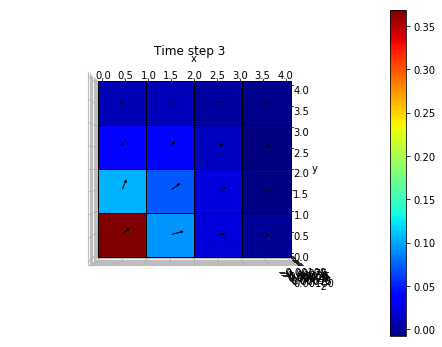

In [11]:
d = np.reshape(d_0, (2, g.num_cells), 'F')
d = np.vstack((d, np.zeros(g.num_cells)))
pp.plot_grid(g, p_0, d, figsize=(8, 6), vector_scale=1/3, if_plot=False)
plt.title("Initial condition")
for t in time_steps:
    d = np.reshape(stored_displacements[t], (2, g.num_cells), 'F')
    d = np.vstack((d, np.zeros(g.num_cells)))
    pp.plot_grid(g, stored_pressures[t], d, figsize=(8, 6), vector_scale=10, if_plot=False)
    plt.title("Time step {}".format(str(t + 1)))
plt.show()